In [1]:
# Importing Libraries for Quantum Machine Learning and Visualization

# PennyLane is a library for quantum machine learning, quantum computing, and quantum chemistry.
# It is used here for creating and optimizing quantum circuits.
import pennylane as qml

# NumPy is a fundamental package for scientific computing with Python.
# We use the version from PennyLane to ensure compatibility with quantum tensors.
from pennylane import numpy as np

# Matplotlib's pyplot is a collection of functions that make matplotlib work like MATLAB.
# It is used here for plotting and visualizing data in a professional manner.
from matplotlib import pyplot as plt

In [2]:
# Defining the Quantum Circuit for QFT
def qft_circuit(params, num_qubits):
    """
    Constructs the quantum circuit for Quantum Fourier Transform (QFT).

    Args:
    params (np.ndarray): Parameters for the variational circuit.
    num_qubits (int): Number of qubits in the circuit.

    Returns:
    np.ndarray: Probability distribution over the quantum states.
    """
    dev = qml.device('default.qubit', wires=num_qubits)
    @qml.qnode(dev)
    def circuit():
        for wire in range(num_qubits):
            qml.Hadamard(wires=wire)
            qml.RZ(params[wire], wires=wire)
        qml.adjoint(qml.QFT)(wires=range(num_qubits))
        return qml.probs(wires=range(num_qubits))
    
    return circuit()

In [3]:
# Defining the Cost Function
def cost_function(params, target_number, num_qubits):
    """
    Defines the cost function for optimizing the QFT circuit.

    Args:
    params (np.ndarray): Parameters for the variational circuit.
    target_number (int): Target number for QFT, in the range [0, 2^num_qubits - 1].
    num_qubits (int): Number of qubits in the circuit.

    Returns:
    float: Cost associated with the current state of the circuit.
    """
    desired_state = np.zeros(2**num_qubits)
    desired_state[target_number] = 1
    probabilities = qft_circuit(params, num_qubits)
    return np.sum(np.square(desired_state - probabilities))

In [4]:
# Optimization Function
def optimize_qft_circuit(num_qubits, target_number, num_steps, lr=0.01):
    """
    Optimizes the QFT circuit using the RMSProp optimizer.

    Args:
    num_qubits (int): Number of qubits in the quantum circuit.
    target_number (int): Target number for QFT, in the range [0, 2^num_qubits - 1].
    num_steps (int): Number of iterations for the optimization process.
    lr (float, optional): Learning rate for the optimizer. Default is 0.01.

    Returns:
    tuple: Optimized parameters, parameter history, cost history, and the final cost value.
    """
    optimizer = qml.RMSPropOptimizer(stepsize=lr)
    params = np.zeros(num_qubits)
    param_history = np.empty([num_steps, num_qubits])
    cost_history = np.empty(num_steps)

    for i in range(num_steps):
        params = optimizer.step(lambda p: cost_function(p, target_number, num_qubits), params)
        param_history[i] = params
        cost_history[i] = cost_function(params, target_number, num_qubits)

    return params, param_history, cost_history, cost_function(params, target_number, num_qubits)

In [5]:
def plot_opt_surface(cost_arr, params, m, cost, n=200):
    # Data array
    theta1 = np.linspace(-2*np.pi, 2*np.pi, n)
    theta2 = np.linspace(-2*np.pi, 2*np.pi, n)
    # Grid of elements
    X, Y = np.meshgrid(theta1, theta2)
    # Cost function on grid
    z = []
    for y in Y:
        for x in X[0]:
            z.append(cost([x, y[0]]))
    Z = np.reshape(z, (n, n))

    #Plotting the cost function of grid
    fig = plt.figure(figsize = (9,9))
    ax = fig.add_subplot(projection='3d')
    ax.plot_wireframe(X, Y, Z, rstride=10, cstride=10, edgecolor = 'grey', linewidth=0.5)

    # Plotting the optimization result
    param1, param2 = np.split(params,2, axis = 1)
    ax.scatter(param1, param2, cost_arr, c = 'red', s = 20, marker = 'o')
    
    # Set labels
    ax.set_xlabel(r'$\theta_1$')
    ax.set_ylabel(r'$\theta_2$')
    ax.set_zlabel('Cost')
    ax.set_title(r'Optimization of Quantum Circuit Using RMSProp Optimizer')
    ax.legend(('Grid of cost function', 'Optimization results'))

In [6]:
# Using the Optimized QFT Circuit
# Setting parameters for the quantum Fourier transform
num_qubits = 2  # Number of qubits
target_number = 3  # Target number for QFT
num_steps = 500  # Number of optimization steps
learning_rate = 0.01  # Learning rate for the optimizer

# Optimizing the QFT circuit
optimized_params, param_history, cost_history, final_cost = optimize_qft_circuit(
    num_qubits, target_number, num_steps, learning_rate
)

# Displaying the results of the optimization
print(f"Optimized rotation angles: {optimized_params}")
print(f"Final cost value: {final_cost}")

Optimized rotation angles: [ 3.13004709 -1.57079633]
Final cost value: 1.665795132691471e-09


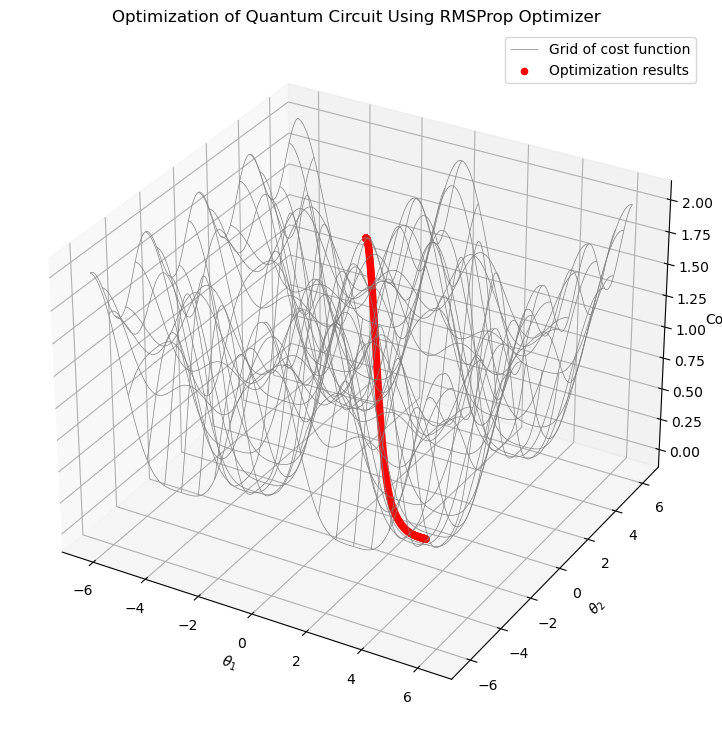

In [7]:
# Visualization of the Optimization Process
# Parameters for the visualization
target_value = 3  # Target value used in the QFT circuit

# Plotting the optimization surface
# The function plot_opt_surface is assumed to require the cost history, parameter history,
# target value, and the cost function itself as arguments to create a surface plot
plot_opt_surface(cost_history, param_history, target_value, lambda p: cost_function(p, target_value, num_qubits))

# Description: This plot visualizes the optimization landscape over the iterations. 
# It demonstrates how the parameters evolved and the cost function decreased over time.